### Learning spliting

![alt text](images/data_split.png)

In [31]:
import os
import sys
#pip loguru
from loguru import logger
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging (1)

In [32]:
logger.remove()  # Remove the default logger
logger.add(sys.stdout, level="INFO")  # Add a new logger that outputs to stderr

4

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten

Create initial data sets:
 * Load data
 * Normalization of predictors set (devide to 255 to set them between 0 and 1)
 * Notmalization of outputs (set it categorical)

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Split train data to:
  * Train set
  * Validation set - type of train data that can be used to ensure in learning curve

In [35]:
def train_data_split_seq(x_train, y_train, split_ratio=0.8):
    '''
    # Split the training data into training and validation sets by split ratio (Default 80% to 20%).
    # The split ratio determines the proportion of data used for training.
    '''
    split_index = int(0.8 * len(x_train))
    x_train_split = x_train[:split_index]
    y_train_split = y_train[:split_index]
    x_val_split = x_train[split_index:]
    y_val_split = y_train[split_index:]
    return x_train_split, x_val_split, y_train_split, y_val_split

In [36]:
def model_fn(optimizer=None):
  model =  Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
  ])
  if optimizer is None:
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  else:
    model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [37]:
def fit_model(model, x_train, y_train, epochs=5, batch_size=32, verbose=0, validation_data=None):
  '''Train the model with the given parameters.
  # Parameters:
  # - model: The model to be trained.
  # - x_train: The training data.
  # - y_train: The training labels.
  # - epochs: The number of epochs to train the model.
  # - batch_size: The size of the batches of data.
  # - verbose: Verbosity mode (0, 1, or 2).
  # - validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch.
  # Returns:
  # - history: A History object containing the training history.
  # '''
  logger.info("Training the model...")
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=validation_data)
  logger.info("Model training completed.")
  logger.debug(f"Model summary: {history.history}")
  return history

Create model:

In [38]:
model = model_fn()

C:\Users\ebliacher.CORPORATE\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train model without validation set

In [39]:
x_loc_train, x_loc_val, y_loc_train, y_loc_val = train_data_split_seq(x_train, y_train, split_ratio=0.8)
history = fit_model(model, x_train, y_train, epochs=5, verbose=0)

2025-04-01 09:39:16.892 | INFO     | __main__:fit_model:14 - Training the model...
2025-04-01 09:39:31.626 | INFO     | __main__:fit_model:16 - Model training completed.


Train model with sequantial validation set

In [40]:
x_seq_train, x_seq_val, y_seq_train, y_seq_val = train_data_split_seq(x_train, y_train, split_ratio=0.8)
history_seq = fit_model(model, x_seq_train, y_seq_train, epochs=5, verbose=0, validation_data=(x_seq_val, y_seq_val))

2025-04-01 09:39:31.636 | INFO     | __main__:fit_model:14 - Training the model...
2025-04-01 09:39:50.761 | INFO     | __main__:fit_model:16 - Model training completed.


***The problem is:***
  * We split training set sequantial
  * This could be reason for slow learning rate and can couse to learing by linear connected features.


***Solution:***
  Split the train set to validation randomaly.

In [41]:
from sklearn.model_selection import train_test_split
def train_data_split_random(x_train, y_train, split_ratio=0.8):
    '''
    # Split the training data into training and validation sets by random sampling (Default 80% to 20%).
    # The split ratio determines the proportion of data used for training.
    '''
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=(1 - split_ratio), random_state=42)
    logger.info(f"Randomly split data into {len(x_train_split)} training samples and {len(x_val_split)} validation samples.")
    return x_train_split, x_val_split, y_train_split, y_val_split

In [42]:
x_rnd_train, x_rnd_val, y_rnd_train, y_rnd_val = train_data_split_random(x_train, y_train, split_ratio=0.8)
history_random = fit_model(model, x_rnd_train, y_rnd_train, epochs=5, verbose=0, validation_data=(x_rnd_val, y_rnd_val))

2025-04-01 09:39:50.916 | INFO     | __main__:train_data_split_random:8 - Randomly split data into 48000 training samples and 12000 validation samples.
2025-04-01 09:39:50.917 | INFO     | __main__:fit_model:14 - Training the model...
2025-04-01 09:40:09.518 | INFO     | __main__:fit_model:16 - Model training completed.


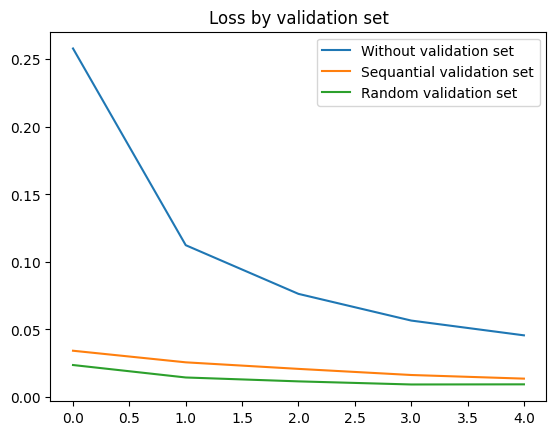

In [43]:
plt.plot(history.history['loss'], label='Without validation set')
plt.plot(history_seq.history['loss'], label='Sequantial validation set')
plt.plot(history_random.history['loss'], label='Random validation set')
plt.title('Loss by validation set')
plt.legend()